In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dask # just to make sure dask is installed because xarray should use it
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from utils.metrics import find_rank, find_quantile_index, compute_chi_squared, compute_cdf, compute_sum_of_squared_deviations
from utils.plot import plot_rank_hist, calibration_plot, calibration_plot_range

sns.set_theme(style='whitegrid')
np.set_printoptions(suppress=True)

In [3]:
SAVE_DIR = Path('../figures/')
DISPLAY = True # whether to display plots in notebook (they are saved to files in either case)

In [5]:
exp = xr.open_zarr(
    '/net/argon/landclim/kraftb/machflow_engression/runs_expectiles/default/xval/fold_000/preds.zarr/'
).isel(time=slice(365, None))
exp = exp.where((exp.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod']].compute()

eng = xr.open_zarr(
    '/net/argon/landclim/kraftb/machflow_engression/runs_timesplit/combined.zarr/'
).isel(time=slice(365, None)).sel(beta=0.67, esl=5, nl=100)
eng = eng.where((eng.folds > 0).compute(), drop=True)[['Qmm', 'Qmm_mod']].compute()

In [7]:
pred = exp.Qmm_mod
obs = exp.Qmm

In [23]:
station_obs = obs.sel(station='CHFO-0057')
station_pred = pred.sel(station='CHFO-0057')

ranks = xr.apply_ufunc(
    find_rank,
    station_obs.compute(),              # Observations with ["time"]
    station_pred.compute(),             # Expectile predictions with ["member", "time"]
    input_core_dims=[[], ["member"]],   # Observations have no "member" dim, members do
    output_core_dims=[[]],              # Output is scalar per observation
    vectorize=True,                     # Apply function element-wise
    dask="parallelized",                # Enable Dask parallelization if needed
    output_dtypes=[np.int16],           # Output type
)

ranks = ranks.compute().data.flatten() # Work with flat numpy array
ranks = ranks[ranks != -1]

expectile_indices = ranks - 1
expectiles = pred.member.values[1:-1]

def compute_cdf(quantile_indices: np.ndarray, num_quantiles: int) -> np.ndarray:
    cumulative_counts = np.zeros(shape=num_quantiles+1)
    for el in quantile_indices:
        cumulative_counts[el:] += 1

    cdf = cumulative_counts / len(quantile_indices)
    cdf = cdf[:-1] # the last element is just 1.0 (highest quantile index is for all values larger than last quantile)

    return cdf

cdf_pred = compute_cdf(quantile_indices=expectile_indices, num_quantiles=len(expectiles))

In [24]:
ranks

array([ 81, 102,  62, ...,  50, 102, 102], dtype=int16)

In [25]:
expectile_indices

array([ 80, 101,  61, ...,  49, 101, 101], dtype=int16)

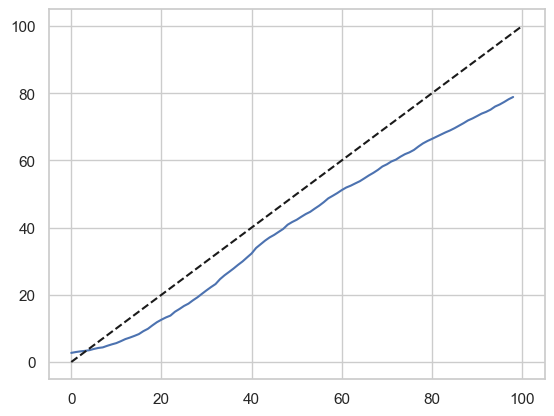

In [30]:
plt.plot(cdf_pred * 100)
plt.plot([0, 100], [0, 100], 'k--')

## Compute ranks

In [6]:
comb_results = {}
comb_cdf = {}

for ds_name, ds in zip(['exp', 'eng'], [exp, eng]):
    pred = ds.Qmm_mod
    obs = ds.Qmm

    results = {}
    cdfs = []
    for station in tqdm(pred.station):
        results[station.data.item()] = {}
        station_obs = obs.sel(station=station)
        station_pred = pred.sel(station=station)

        ranks = xr.apply_ufunc(
            find_rank,
            station_obs.compute(),              # Observations with ["time"]
            station_pred.compute(),             # Expectile predictions with ["member", "time"]
            input_core_dims=[[], ["member"]],   # Observations have no "member" dim, members do
            output_core_dims=[[]],              # Output is scalar per observation
            vectorize=True,                     # Apply function element-wise
            dask="parallelized",                # Enable Dask parallelization if needed
            output_dtypes=[np.int16],           # Output type
        )

        ranks = ranks.compute().data.flatten() # Work with flat numpy array
        ranks = ranks[ranks != -1]
        chi_squared = compute_chi_squared(ranks=ranks, num_members=len(station_pred.member))
        results[station.data.item()]['Chi^2'] = chi_squared

        if ds_name == 'exp':
            expectile_indices = ranks - 1
            expectiles = ds.member.values[1:-1]

            cdf_pred = compute_cdf(quantile_indices=expectile_indices, num_quantiles=len(expectiles))
            cdfs.append(cdf_pred)
            sum_of_squared_deviations = compute_sum_of_squared_deviations(expectiles, cdf_pred)
            results[station.data.item()]['RSS'] = sum_of_squared_deviations

        else:
            quantiles = np.arange(start=0.01, stop=1.0, step=0.01)
            quantile_values = station_pred.quantile(quantiles, dim='member')
            quantile_indices = xr.apply_ufunc(
                find_quantile_index,
                station_obs,                        # Observations with ["time"]
                quantile_values,                    # Quantiles with ["quantile", "time"]
                input_core_dims=[[], ["quantile"]], # Observations have no "quantile", quantiles do
                output_core_dims=[[]],              # Output is scalar per observation
                vectorize=True,                     # Apply function element-wise
                dask="parallelized",                # Enable Dask parallelization if needed
                output_dtypes=[np.int16],           # Output type
            )

            quantile_indices = quantile_indices.compute().data.flatten() # Work with flat numpy array
            quantile_indices = quantile_indices[quantile_indices != -1]
            
            cdf_pred = compute_cdf(quantile_indices=quantile_indices, num_quantiles=len(quantiles))
            cdfs.append(cdf_pred)
            sum_of_squared_deviations = compute_sum_of_squared_deviations(quantiles, cdf_pred)
            results[station.data.item()]['RSS'] = sum_of_squared_deviations

    comb_results[ds_name] = results
    comb_cdf[ds_name] = cdfs


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

## Compute NSE

In [7]:
def compute_nse(ds: xr.Dataset):
    dsc = ds.copy()
    mask = dsc.Qmm.notnull() & dsc.Qmm_mod.notnull()
    dsc = dsc.where(mask)
    
    se = (dsc.Qmm - dsc.Qmm_mod)**2
    so = (dsc.Qmm - dsc.Qmm.mean('time'))**2
    return 1 - se.sum('time') / so.sum('time')


In [8]:
nse = xr.Dataset()
nse['exp'] = compute_nse(exp.sel(member=0.5))
nse['eng'] = compute_nse(eng.median('member'))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


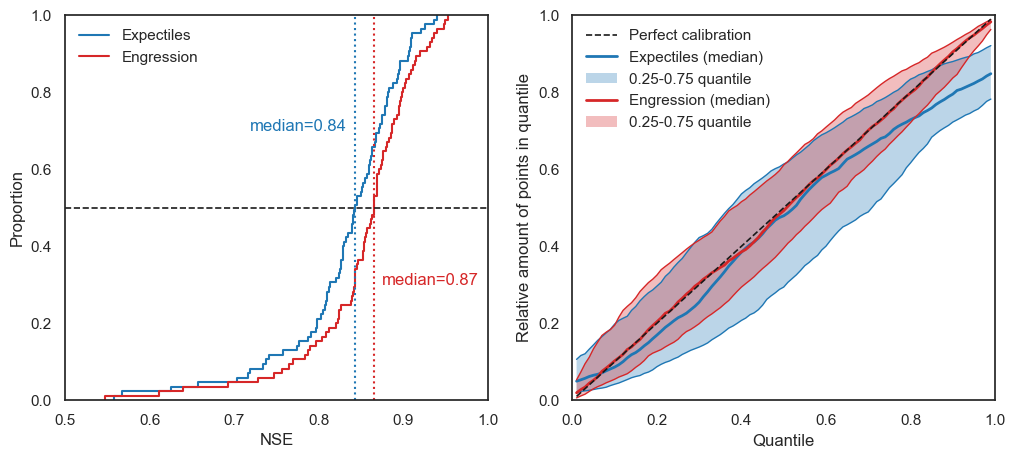

In [15]:
sns.set_theme(style='white')

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax = axes[0]

sns.ecdfplot(nse.exp, color='tab:blue', label='Expectiles', ax=ax)
sns.ecdfplot(nse.eng, color='tab:red', label='Engression', ax=ax)

nse_median = nse.median()
ax.axvline(nse_median.exp, ls=':', color='tab:blue')
ax.text(nse_median.exp - 0.01, 0.7, f'median={nse_median.exp.item():0.2f}', ha='right', color='tab:blue')

nse_median = nse.median()
ax.axvline(nse_median.eng, ls=':', color='tab:red')
ax.text(nse_median.eng + 0.01, 0.3, f'median={nse_median.eng.item():0.2f}', ha='left', color='tab:red')

ax.axhline(0.5, color='k', ls='--', lw=1.2)

ax.set_xlim(0.5, 1)
ax.set_xlabel('NSE')
ax.set_ylabel('Proportion')

ax.legend(frameon=False)

ax = axes[1]

for name, name_nice in zip(['exp', 'eng'], ['Expectiles', 'Engression']):
    cdf = np.stack(comb_cdf[name])
    x = np.arange(start=0.01, stop=1.0, step=0.01)

    if name == 'exp':
        color = 'tab:blue'
        sns.lineplot(x=x, y=x, ax=ax, label=f'Perfect calibration', color='k', linestyle='--', lw=1.2, zorder=-5)
    else:
        color = 'tab:red'

    med = np.median(cdf, axis=0)
    low = np.quantile(cdf, 0.25, axis=0)
    high = np.quantile(cdf, 0.75, axis=0)

    sns.lineplot(x=x, y=med, ax=ax, label=f'{name_nice} (median)', color=color, zorder=-10, lw=2)
    sns.lineplot(x=x, y=low, ax=ax, color=color, zorder=-10, lw=1)
    sns.lineplot(x=x, y=high, ax=ax, color=color, zorder=-10, lw=1)

    ax.fill_between(
        x=x, y1=low, y2=high, ec='none', fc=color, alpha=0.3, zorder=-20, label=f'0.25-0.75 quantile')

ax.set_rasterization_zorder(-5)
ax.set_xlabel('Quantile')
ax.set_ylabel('Relative amount of points in quantile')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(frameon=False)

fig.savefig(SAVE_DIR / 'calibration_plot.eps', dpi=300, bbox_inches='tight')